In [1]:
! pip install tensorflow matplotlib deepface scikit-learn

You should consider upgrading via the 'c:\users\shubham\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [1]:
#from deepface import DeepFace
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import glob
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, PReLU
from tensorflow.keras.layers import Activation, Concatenate, Lambda, add, ZeroPadding2D, Input, Add, Reshape
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model

from tensorflow.python.keras import backend
from tensorflow.python.keras.engine import training
from tensorflow.python.keras.utils import data_utils, layer_utils
from tensorflow.python.lib.io import file_io
from tensorflow import keras
from tensorflow.keras import backend as K

from pathlib import Path
import gdown

from deepface.commons import functions

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)

In [3]:
data_dir = os.path.join("Dataset", "Image_Data") 

In [4]:
person_no = 1
filter_no = 9
person_dir = os.path.join(data_dir, str(person_no)) 
filename = os.path.join(person_dir, "{}_Filtered_{}.jpg".format(person_no, filter_no))

In [7]:
img_height,img_width=256,256
batch_size=16
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2040 files belonging to 102 classes.
Using 1632 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2040 files belonging to 102 classes.
Using 204 files for validation.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2040 files belonging to 102 classes.
Using 204 files for validation.


In [10]:
classnames = train_ds.class_names
classnames

['1',
 '10',
 '100',
 '101',
 '102',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

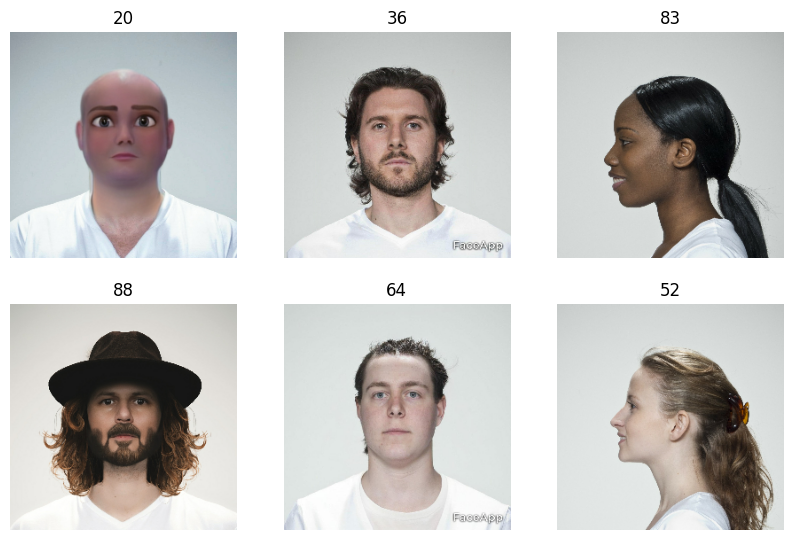

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[np.argmax(labels[i])])
    plt.axis("off")

In [12]:
#url = "https://drive.google.com/uc?id=1LVB3CdVejpmGHM28BpqqkbZP5hDEcdZY"
def scaling(x, scale):
	return x * scale

def loadModel():
    model = Sequential()
    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                       input_shape=(img_height,img_width,3),
                       pooling='avg',
                       classes=len(classnames),
                       weights='imagenet')
    for layer in pretrained_model.layers:
            layer.trainable=False
    
    model.add(pretrained_model)
    embedding = pretrained_model.outputs[0]
    embedding = loadInceptionResnetV1(embedding)
    inceptionModel = keras.models.Model(pretrained_model.outputs[0], embedding, name='inception-resnet-v1')
    model.add(inceptionModel)
    model.add(Flatten())
    model.add(Dense(len(classnames), activation='softmax'))
    
    return model, pretrained_model, inceptionModel
    

def loadInceptionResnetV1(embedding):
    embedding = tf.expand_dims(embedding, axis=-2)
    embedding = tf.expand_dims(embedding, axis=-2)
    
    # Block17 (Inception-ResNet-B block):
    branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_0_Conv2d_1x1')(embedding)
    branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
    branch_0 = Activation('relu', name='Block17_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
    branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0a_1x1') (embedding)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
    branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
    branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0b_1x7') (branch_1)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0b_1x7_BatchNorm')(branch_1)
    branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0b_1x7_Activation')(branch_1)
    branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0c_7x1') (branch_1)
    branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0c_7x1_BatchNorm')(branch_1)
    branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0c_7x1_Activation')(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name='Block17_1_Concatenate')(branches)
    up = Conv2D(2048, 1, strides=1, padding='same', use_bias=True, name= 'Block17_1_Conv2d_1x1') (mixed)
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
    embedding = add([embedding, up])
    embedding = Activation('relu', name='Block17_1_Activation')(embedding)
    return embedding
    
    

def ResNet34():

	img_input = Input(shape=(112, 112, 3))

	x = ZeroPadding2D(padding=1, name='conv1_pad')(img_input)
	x = Conv2D(64, 3, strides=1, use_bias=False, kernel_initializer='glorot_normal', name='conv1_conv')(x)
	x = BatchNormalization(axis=3, epsilon=2e-5, momentum=0.9, name='conv1_bn')(x)
	x = PReLU(shared_axes=[1, 2], name='conv1_prelu')(x)
	x = stack_fn(x)

	model = training.Model(img_input, x, name='Resnet34')

	return model

def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
	bn_axis = 3

	if conv_shortcut:
		shortcut = Conv2D(filters, 1, strides=stride, use_bias=False, kernel_initializer='glorot_normal', name=name + '_0_conv')(x)
		shortcut = BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_0_bn')(shortcut)
	else:
		shortcut = x

	x = BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_1_bn')(x)
	x = ZeroPadding2D(padding=1, name=name + '_1_pad')(x)
	x = Conv2D(filters, 3, strides=1, kernel_initializer='glorot_normal', use_bias=False, name=name + '_1_conv')(x)
	x = BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_2_bn')(x)
	x = PReLU(shared_axes=[1, 2], name=name + '_1_prelu')(x)

	x = ZeroPadding2D(padding=1, name=name + '_2_pad')(x)
	x = Conv2D(filters, kernel_size, strides=stride, kernel_initializer='glorot_normal', use_bias=False, name=name + '_2_conv')(x)
	x = BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_3_bn')(x)

	x = Add(name=name + '_add')([shortcut, x])
	return x

def stack1(x, filters, blocks, stride1=2, name=None):
	x = block1(x, filters, stride=stride1, name=name + '_block1')
	for i in range(2, blocks + 1):
		x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
	return x

def stack_fn(x):
	x = stack1(x, 64, 3, name='conv2')
	x = stack1(x, 128, 4, name='conv3')
	x = stack1(x, 256, 6, name='conv4')
	return stack1(x, 512, 3, name='conv5')

In [13]:
model, pretrained_model, inceptionModel = loadModel()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 inception-resnet-v1 (Functi  (None, 1, 1, 2048)       1281536   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 25,078,246
Trainable params: 1,489,510
Non-trainable params: 23,588,736
_________________________________________________________________


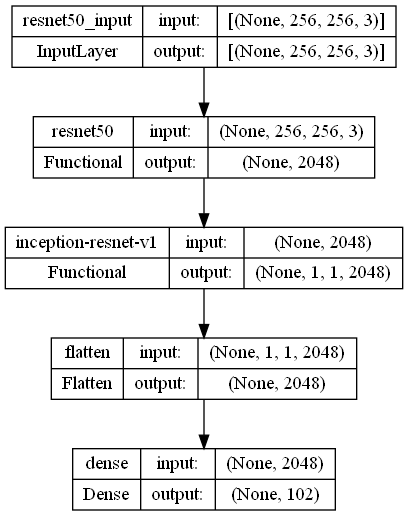

In [15]:
#model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

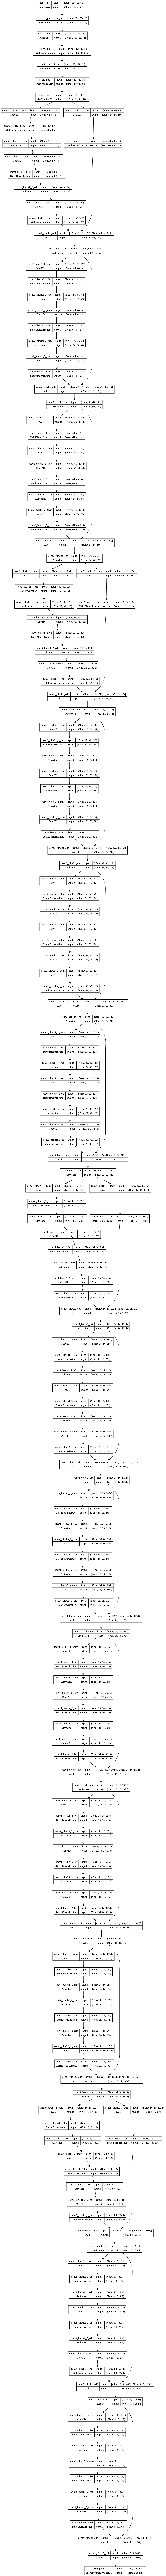

In [16]:
tf.keras.utils.plot_model(pretrained_model, show_shapes=True)

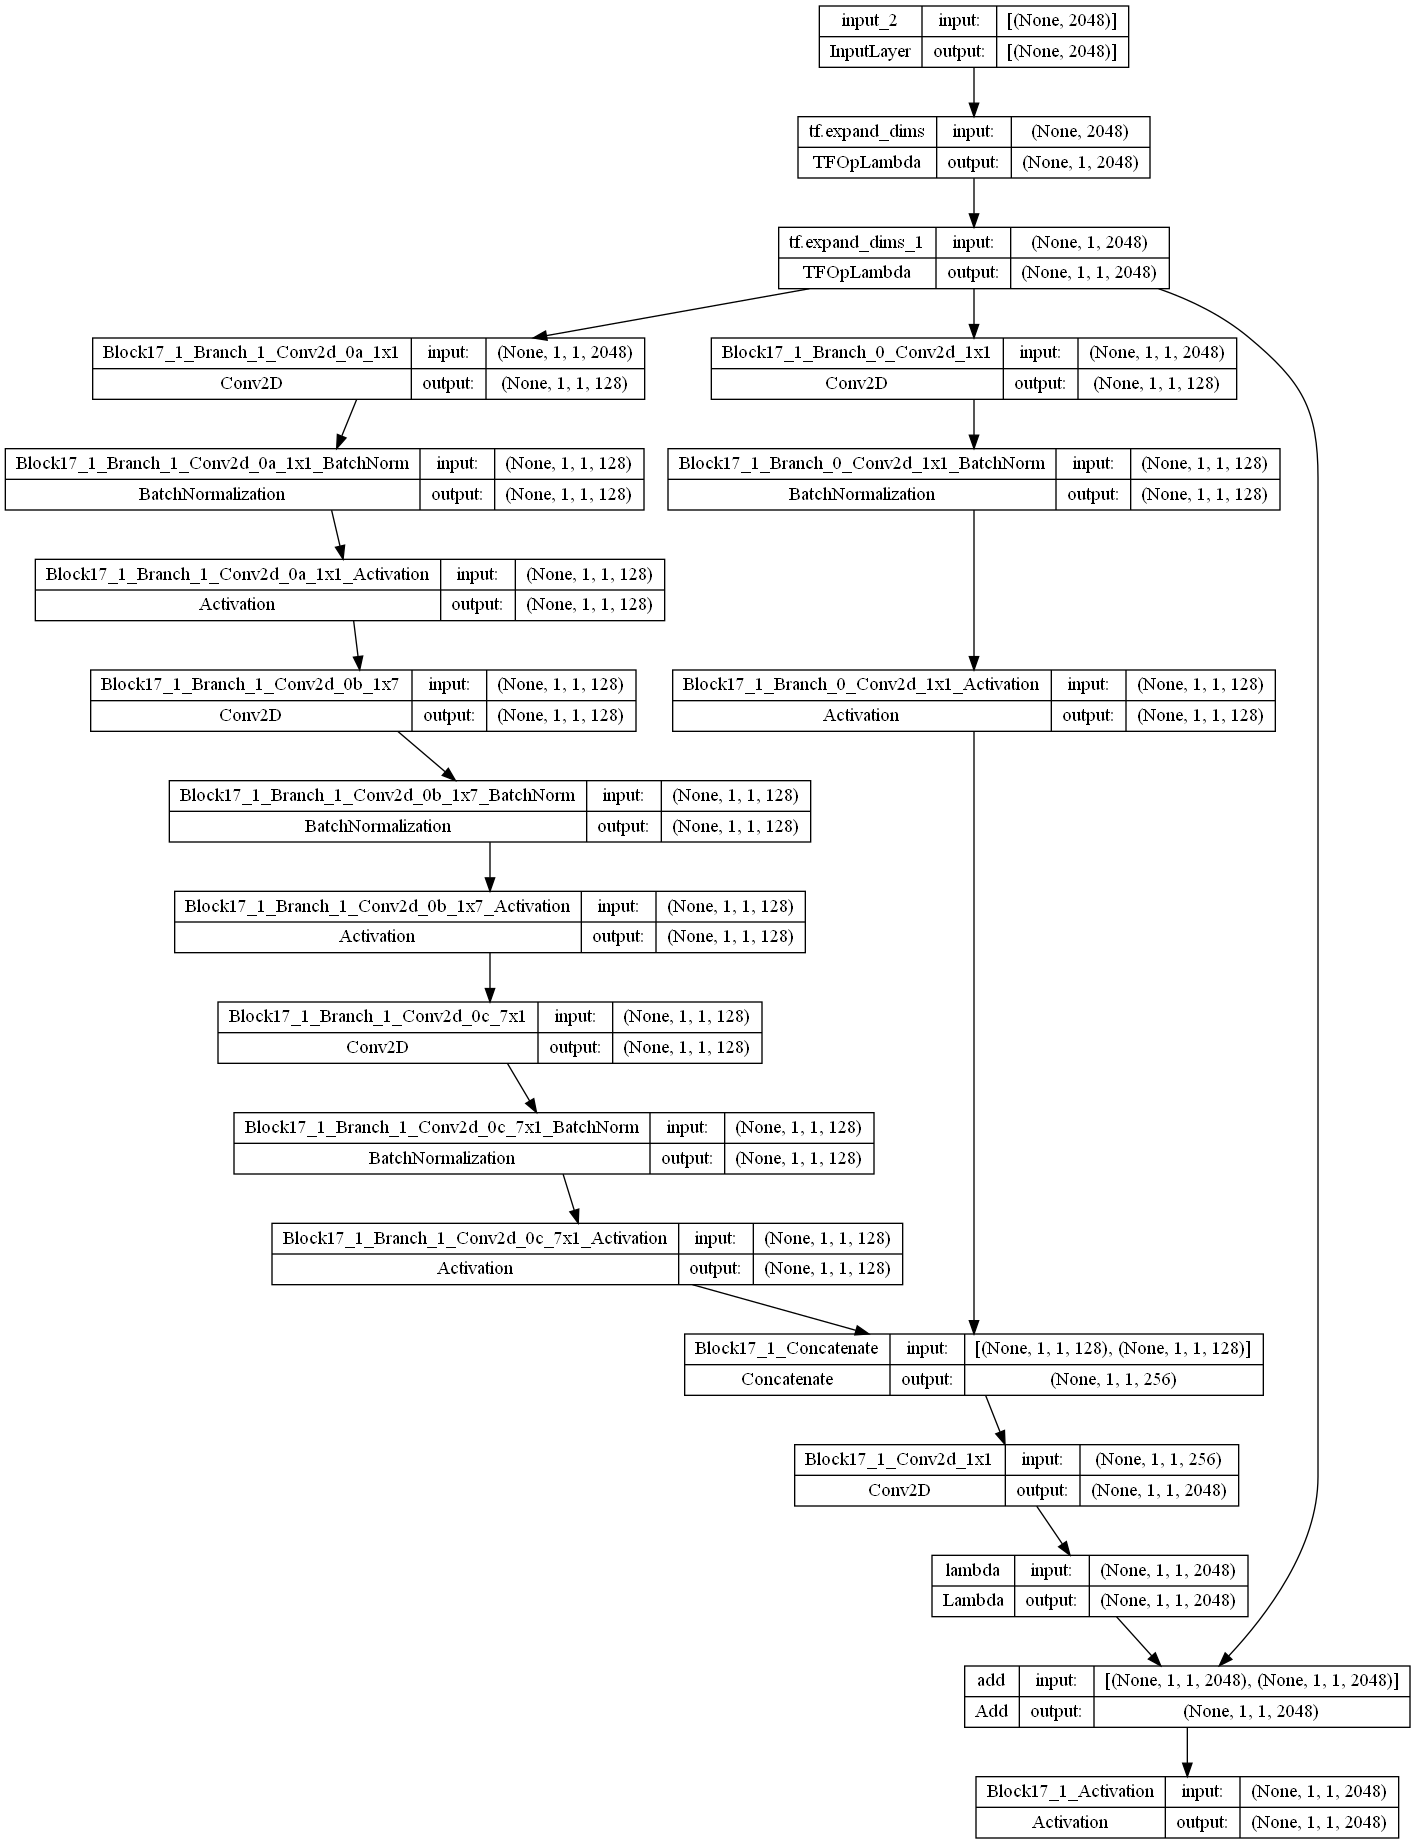

In [17]:
tf.keras.utils.plot_model(inceptionModel, show_shapes=True)

In [18]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
102/102 [==============================] - 289s 3s/step - loss: 4.1982 - accuracy: 0.1520 - val_loss: 3.2229 - val_accuracy: 0.2843
Epoch 2/10
102/102 [==============================] - 252s 2s/step - loss: 1.6133 - accuracy: 0.6716 - val_loss: 2.1711 - val_accuracy: 0.5637
Epoch 3/10
102/102 [==============================] - 258s 2s/step - loss: 0.6497 - accuracy: 0.9020 - val_loss: 1.4476 - val_accuracy: 0.7010
Epoch 4/10
102/102 [==============================] - 266s 3s/step - loss: 0.3465 - accuracy: 0.9442 - val_loss: 1.2397 - val_accuracy: 0.7157
Epoch 5/10
102/102 [==============================] - 297s 3s/step - loss: 0.2259 - accuracy: 0.9638 - val_loss: 1.1151 - val_accuracy: 0.7745
Epoch 6/10
102/102 [==============================] - 315s 3s/step - loss: 0.1480 - accuracy: 0.9755 - val_loss: 0.7141 - val_accuracy: 0.8627
Epoch 7/10
102/102 [==============================] - 257s 2s/step - loss: 0.1076 - accuracy: 0.9798 - val_loss: 0.7552 - val_accuracy: 0.8431

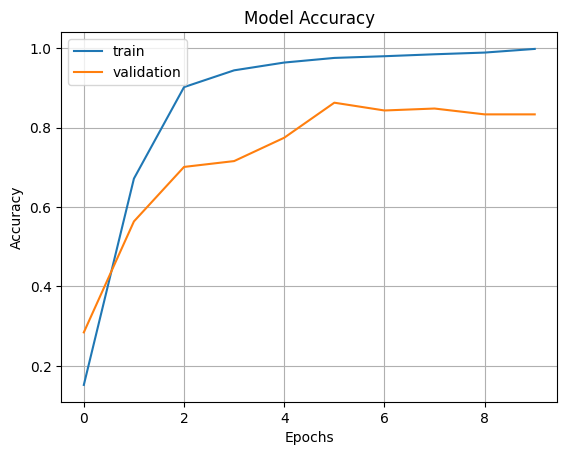

In [20]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
#plt.show()
plt.savefig('Results/Visual Analysis/model_accuracy.pdf', dpi = 700)

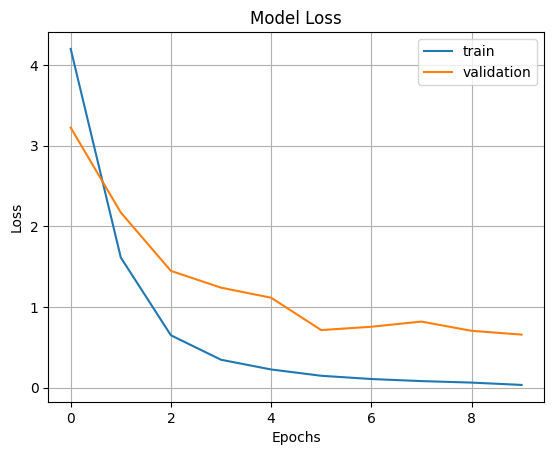

In [21]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
#plt.show()
plt.savefig('Results/Visual Analysis/model_loss.pdf', dpi = 700)

In [22]:
image=cv2.imread(filename)
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)

In [23]:
pred=model.predict(image)
output_class=classnames[np.argmax(pred)]
print("The predicted class is", output_class)

1/1 [==============================] - 8s 8s/step
The predicted class is 1


In [25]:
model.save("weights/action.h5")